<a href="https://colab.research.google.com/github/Rubeennn/Dog_Cat_dataset/blob/main/Cat_Dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip3 install -q kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [4]:
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [5]:
! kaggle datasets download -d unmoved/30k-cats-and-dogs-150x150-greyscale

Dataset URL: https://www.kaggle.com/datasets/unmoved/30k-cats-and-dogs-150x150-greyscale
License(s): CC0-1.0
 98% 130M/133M [00:09<00:00, 18.9MB/s]
100% 133M/133M [00:09<00:00, 14.0MB/s]


In [6]:
from pathlib import Path

data_path = Path('data')

data_path.mkdir(exist_ok=True, parents=True)


In [7]:
import zipfile

with zipfile.ZipFile('30k-cats-and-dogs-150x150-greyscale.zip', 'r') as z:
    z.extractall(data_path)

In [8]:
cat_path = data_path / 'Animal Images' / 'cats'
cat_path
dog_path = data_path / 'Animal Images' / 'dogs'

### Importing the necessary packages

In [9]:
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from tqdm.auto import tqdm
from PIL import Image
from torch import nn
import pandas as pd
import torchvision
import numpy as np
import torch
import time
import os


Shape of the image is: (150, 150)


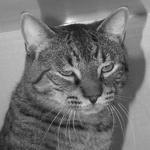

In [10]:
# Visualizing one image
cat_image_names = os.listdir(cat_path)
first_cat_image_path = cat_path / cat_image_names[0]
img = Image.open(fp=first_cat_image_path)
print(f'Shape of the image is: {np.asarray(img).shape}')
img

2. Now we define the path to the image directory
and then gaining the dataset with **ImageFolder**.

In [11]:
data_path

PosixPath('data')

In [12]:
# Device agnostic code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [13]:
dataset = ImageFolder(

    root = data_path / 'Animal Images',
    transform=transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(size=(124,124)), # Maybe need to make it smaller
    transforms.ToTensor()
    ])
)

## 3. Bulding the model

In [16]:
# Splitting the dataset into train, test and validation datasets.

torch.manual_seed(42)

train_size = int(len(dataset) * 0.7)
test_size = int(len(dataset) * 0.15)

val_size = len(dataset) - train_size - test_size

train_dataset, test_dataset, val_dataset = random_split(dataset,
                                                        [train_size,
                                                         test_size,
                                                         val_size]
                                                       )


1. Splitting data into batches using the *DataLoader*.

In [19]:

BATCH_SIZE = 64

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=os.cpu_count()
                             )

test_loader = DataLoader(dataset=test_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        num_workers=os.cpu_count()
                        )

val_loader = DataLoader(dataset=val_dataset,
                       batch_size=BATCH_SIZE,
                       shuffle=False,
                       num_workers=os.cpu_count())

In [18]:
dummy = torch.randint(0,255,size=(1,1,124,124),dtype=torch.float)
conv = nn.Conv2d(in_channels=1,
                                             out_channels=3,
                                             kernel_size=(3,3),
                                             stride=1,
                                             padding=0
                                            )
output = conv(dummy)
output.shape, dummy.shape

(torch.Size([1, 3, 122, 122]), torch.Size([1, 1, 124, 124]))

In [74]:
class miniDogCat(nn.Module):
    def __init__(self, input_shape, hidden_shape,output_shape=1):
        super().__init__()

        self.block1 = nn.Sequential(nn.BatchNorm2d(num_features=1),
                                   nn.Conv2d(in_channels=1,
                                             out_channels=hidden_shape,
                                             kernel_size=(3,3),
                                             stride=1,
                                             padding=0
                                            ),
                                    nn.BatchNorm2d(num_features=hidden_shape),
                                    nn.ReLU(),
                                    nn.Conv2d(in_channels=hidden_shape,
                                              out_channels=hidden_shape,
                                              kernel_size=(3,3),
                                              stride=1,
                                              padding=0
                                    ),
                                    nn.BatchNorm2d(num_features=hidden_shape),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=(3,3),stride=2),
                                    nn.Dropout2d(p=0.15)
                                   )

        self.block2 = nn.Sequential(nn.BatchNorm2d(num_features=hidden_shape),
                                   nn.Conv2d(in_channels=hidden_shape,
                                             out_channels=hidden_shape,
                                             kernel_size=(3,3),
                                             stride=1,
                                             padding=0
                                            ),
                                    nn.BatchNorm2d(num_features=hidden_shape),
                                    nn.ReLU(),
                                    nn.Conv2d(in_channels=hidden_shape,
                                              out_channels=hidden_shape,
                                              kernel_size=(3,3),
                                              stride=1,
                                              padding=1
                                    ),
                                    nn.MaxPool2d(kernel_size=(3,3)),
                                    nn.BatchNorm2d(num_features=hidden_shape),
                                    nn.ReLU(),
                                    nn.Dropout2d(p=0.15))

        self.classifier = nn.Sequential(nn.Flatten(),
                                       nn.Linear(in_features=5415,
                                                out_features=124),
                                        nn.ReLU(),
                                        nn.Dropout2d(p=0.6),
                                        nn.Linear(in_features=124,
                                                 out_features=output_shape)
                                       )
    def forward(self, X):
        # print(X.shape)
        X = self.block1(X)
        # print(X.shape)
        X = self.block2(X)
        # print(X.shape)
        X = self.classifier(X)
        # print(X.shape)
        return X

In [75]:
model = miniDogCat(input_shape=124,
              hidden_shape=15).to(device)

In [76]:
dummy = torch.randint(0, 255, size=(1,1,124,124), dtype=torch.float).to(device)
model(dummy)

tensor([[-0.0905]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [77]:
optimizer = torch.optim.Adam(params=model.parameters(),
                       lr=0.001)

loss = nn.BCEWithLogitsLoss()

In [78]:
len(train_dataloader)

329

In [79]:
model

miniDogCat(
  (block1): Sequential(
    (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(1, 15, kernel_size=(3, 3), stride=(1, 1))
    (2): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Dropout2d(p=0.15, inplace=False)
  )
  (block2): Sequential(
    (0): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1))
    (2): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=

In [80]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []

In [86]:
epochs = 20
start_time = time.time()
for epoch in tqdm(range(epochs)):

    train_total_loss = 0
    train_total_acc = 0
    total_val_loss = 0
    total_val_acc = 0

    for batch , (X,y) in enumerate(train_dataloader):

        X, y = X.to(device), y.to(device)
        model.train()

        y_train_pred_logits = model(X)
        y = y.unsqueeze(dim=-1).to(torch.float)

        y_pred_probas = torch.round(torch.sigmoid(y_train_pred_logits))

        train_loss = loss(y_train_pred_logits, y)
        train_total_loss += train_loss.item()

        train_total_acc += (torch.sum(y_pred_probas == y).item() / len(y)) * 100

        optimizer.zero_grad()

        train_loss.backward()

        optimizer.step()

    train_total_loss /= len(train_dataloader)
    train_total_acc /= len(train_dataloader)
    train_losses.append(train_total_loss)
    train_accs.append(train_total_acc)

    with torch.inference_mode():
        model.eval()
        for (X_val, y_val) in val_loader:

            X_val, y_val = X_val.to(device), y_val.to(device)

            y_val_pred_logits = model(X_val)
            y_val_pred = torch.round(torch.sigmoid(y_val_pred_logits))

            y_val = y_val.unsqueeze(dim=-1).to(torch.float)

            val_loss = loss(y_val_pred_logits, y_val)
            total_val_loss += val_loss.item()

            total_val_acc += (torch.sum(y_val_pred == y_val).item() / len(y_val)) * 100

    total_val_loss /= len(val_loader)
    total_val_acc /= len(val_loader)
    val_losses.append(total_val_loss)
    val_accs.append(total_val_acc)

    print(f'Train loss: {train_total_loss:.4f},train_acc: {train_total_acc:.4f}, Val loss: {total_val_loss:.4f}, val_acc: {total_val_acc:.4f}')

end_time = time.time()
print(f'time spent: {end_time - start_time}')







  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 0.4105,train_acc: 80.8995, Val loss: 0.4350, val_acc: 79.6508
Train loss: 0.4086,train_acc: 81.2331, Val loss: 0.4363, val_acc: 80.0528
Train loss: 0.3940,train_acc: 81.9931, Val loss: 0.4073, val_acc: 80.8891
Train loss: 0.3791,train_acc: 82.9346, Val loss: 0.4074, val_acc: 81.8794
Train loss: 0.3762,train_acc: 82.8183, Val loss: 0.4108, val_acc: 81.7914
Train loss: 0.3670,train_acc: 83.2052, Val loss: 0.4112, val_acc: 81.3322
Train loss: 0.3639,train_acc: 83.0474, Val loss: 0.4191, val_acc: 80.3991
Train loss: 0.3530,train_acc: 83.6826, Val loss: 0.4114, val_acc: 81.6623
Train loss: 0.3379,train_acc: 84.6539, Val loss: 0.4046, val_acc: 81.6124
Train loss: 0.3324,train_acc: 84.9258, Val loss: 0.4070, val_acc: 81.8985
Train loss: 0.3246,train_acc: 85.0956, Val loss: 0.4015, val_acc: 82.6276
Train loss: 0.3297,train_acc: 84.9078, Val loss: 0.4068, val_acc: 81.9865
Train loss: 0.3191,train_acc: 85.2273, Val loss: 0.4138, val_acc: 82.4076
Train loss: 0.3102,train_acc: 85.7996,

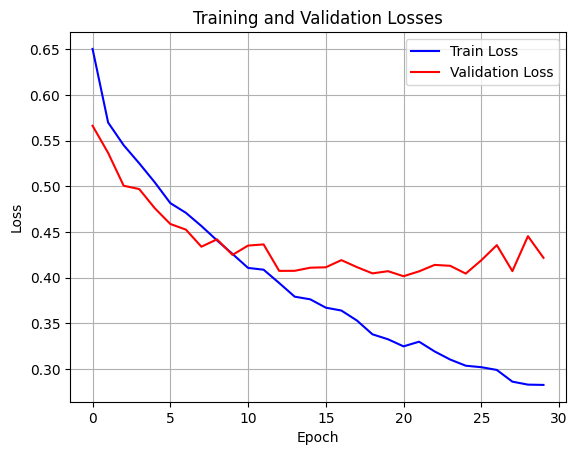

In [87]:
import matplotlib.pyplot as plt

# Assuming train_losses and val_losses are lists or arrays containing your losses

plt.plot(range(len(train_losses)), train_losses, c='b', label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, c='r', label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')

plt.legend()
plt.grid(True)
plt.show()


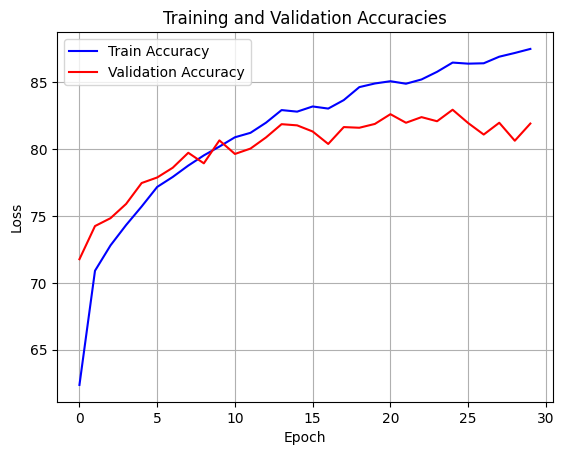

In [88]:
import matplotlib.pyplot as plt

# Assuming train_losses and val_losses are lists or arrays containing your losses

plt.plot(range(len(train_accs)), train_accs, c='b', label='Train Accuracy')
plt.plot(range(len(val_accs)), val_accs, c='r', label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Accuracies')

plt.legend()
plt.grid(True)
plt.show()